Reads in all SLCs and calculates TPC over time for each pixel then calculate average TPC for each. 
<br>

written on 5-1-2023.
***

In [1]:
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter, uniform_filter
%matplotlib  widget

In [2]:
workdir = '/data/ocp4/LagunaSalada/Data_and_Figs/'
cropdir = 'cropped_9000_1800_18000_3600/'

# how much to downlook?
# alooks=40
# rlooks=200

alooks=8
rlooks=20
print(alooks,rlooks)

dates = [os.path.basename(x) for x in glob.glob(workdir+cropdir+"SLC_vv/2*")]
dates=sorted(dates)
nd=len(dates); numIgrams = nd-1; numTriplets = nd-2
print(str(nd)+' dates!') 

#larger area
dx = 4000
dy = 1100

8 20
211 dates!


This next cell only works if I don't have a ton of variables saved on RAM. 

In [4]:
SLCs = np.zeros((nd,dy,dx),dtype='complex')

# larger box with western mtns
x1 = 18000; x2 = 14000
y1 = 2100;  y2 = 1000

# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')

# loop through the dates 
for i in range(nd): # numIgrams if doing all of them at once
    ds = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                    gdal.GA_ReadOnly)
    SLCs[i] = ds.GetRasterBand(1).ReadAsArray(x2,y2,x1-x2,y1-y2)
print('SLCs loaded.')

SLCs loaded.


In [5]:
# make igrams
seq = SLCs[0:-1,:,:]*np.conj(SLCs[1:,:,:])    # sequential, so ab, bc
skip1 = SLCs[2:,:,:]*np.conj(SLCs[0:-2,:,:])  # skip1 BUT REVERSED, so ca
print('Sequential and skip1 igrams made.')

Sequential and skip1 igrams made.


Make sure I know how the Gaussian filter works by using it on a delta function. 

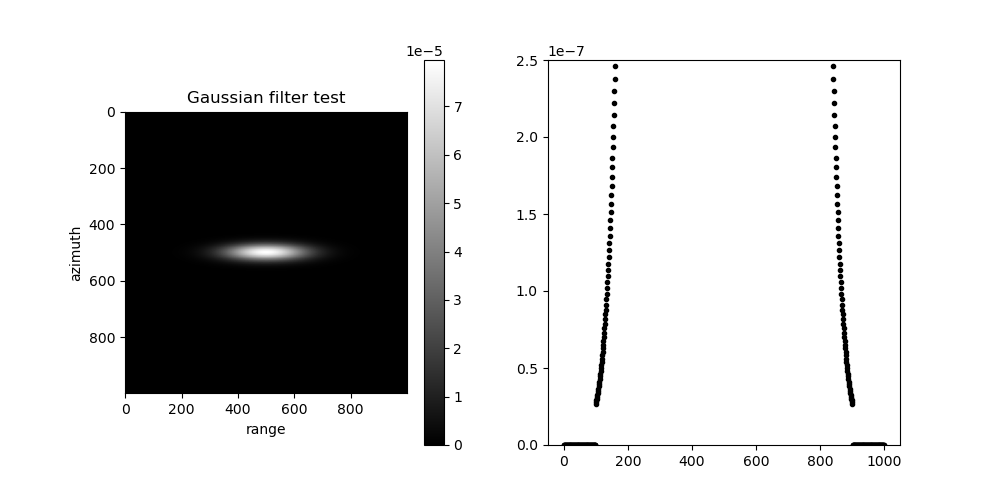

2.669844173025905e-08
100
Peak of Gaussian: 7.958693311738389e-05
Jump at edge of Gaussian: 2.669844173025905e-08
This is a 0.033546262790251184% jump
and it jumps down to zero (edge of filter) at the filter width away from center.


In [ ]:
test_array = np.zeros((1000,1000))
test_array[500,500] = 1.0
test_array_filt = gaussian_filter(test_array, sigma=[alooks/2,rlooks/2])

# plot it.
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(test_array_filt, cmap='gray',aspect='equal',interpolation='nearest')
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('Gaussian filter test') 
plt.colorbar(); 
plt.subplot(1,2,2)
plt.plot(range(1000),test_array_filt[500,:],'k.')
plt.ylim([0,0.25e-6])
plt.show()

non_zero_vals = test_array_filt[500,(np.nonzero(test_array_filt[500,:]))].flatten()
#print(np.shape(non_zero_vals))
print(non_zero_vals[0])
non_zero_x = np.nonzero(test_array_filt[500,:])[0]
#print(non_zero_x)
#print(np.shape(non_zero_x[0]))
print(non_zero_x[0])

print('Peak of Gaussian: '+str(max(non_zero_vals)))
print('Jump at edge of Gaussian: '+str(non_zero_vals[0]))
print('This is a '+str((non_zero_vals[0]/max(non_zero_vals))*100)+'% jump')
print('and it jumps down to zero (edge of filter) at the filter width away from center.')

In [6]:
# loop through dates and calculate TPCs spatially for each triplet 
TPC = np.ndarray((numTriplets,dy,dx),dtype='float')

# make a large array (10sigma) of zeros with one one and filter it, see how far the filter extends 
# what is the kernel
# convolving a delta function to get the filter 
# see what the "drop" is at the edge, 10% of the peak is probably too much 
# can make my own kernel and conv2 to convolve it across the data 
#

for i in range(numTriplets):
    # filter seq igram ab 
    ab_filt_r = gaussian_filter(np.real(seq[i]), sigma=[alooks/2,rlooks/2]) # 
    ab_filt_i = gaussian_filter(np.imag(seq[i]), sigma=[alooks/2,rlooks/2]) # Check older code to make sure dividing by 4 was correct for older application 
    ab_filt =   ab_filt_r + 1j*ab_filt_i
    # filter seq igram bc
    bc_filt_r = gaussian_filter(np.real(seq[i+1]), sigma=[alooks/2,rlooks/2])
    bc_filt_i = gaussian_filter(np.imag(seq[i+1]), sigma=[alooks/2,rlooks/2])
    bc_filt =   bc_filt_r + 1j*bc_filt_i
    # filter skip1 igram ac
    ca_filt_r = gaussian_filter(np.real(skip1[i]), sigma=[alooks/2,rlooks/2])
    ca_filt_i = gaussian_filter(np.imag(skip1[i]), sigma=[alooks/2,rlooks/2]) 
    ca_filt =   ca_filt_r + 1j*ca_filt_i
    # calculate the triplet 
    TPC[i] = np.angle(ab_filt * bc_filt * ca_filt)
    print('TPCs calculated for igram triplet '+str(i))
print('All TPCs calculated.')

TPCs calculated for igram triplet 0
TPCs calculated for igram triplet 1
TPCs calculated for igram triplet 2
TPCs calculated for igram triplet 3
TPCs calculated for igram triplet 4
TPCs calculated for igram triplet 5
TPCs calculated for igram triplet 6
TPCs calculated for igram triplet 7
TPCs calculated for igram triplet 8
TPCs calculated for igram triplet 9
TPCs calculated for igram triplet 10
TPCs calculated for igram triplet 11
TPCs calculated for igram triplet 12
TPCs calculated for igram triplet 13
TPCs calculated for igram triplet 14
TPCs calculated for igram triplet 15
TPCs calculated for igram triplet 16
TPCs calculated for igram triplet 17
TPCs calculated for igram triplet 18
TPCs calculated for igram triplet 19
TPCs calculated for igram triplet 20
TPCs calculated for igram triplet 21
TPCs calculated for igram triplet 22
TPCs calculated for igram triplet 23
TPCs calculated for igram triplet 24
TPCs calculated for igram triplet 25
TPCs calculated for igram triplet 26
TPCs calcul

In [7]:
# average over time 
avg_TPCs = np.mean(TPC,axis=0)
std_TPCs = np.std(TPC, axis=0)
print(np.shape(avg_TPCs))
print(np.shape(std_TPCs))

(1100, 4000)
(1100, 4000)


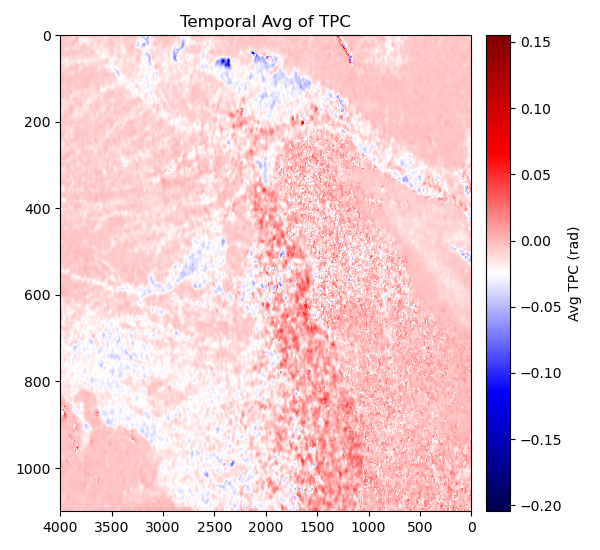

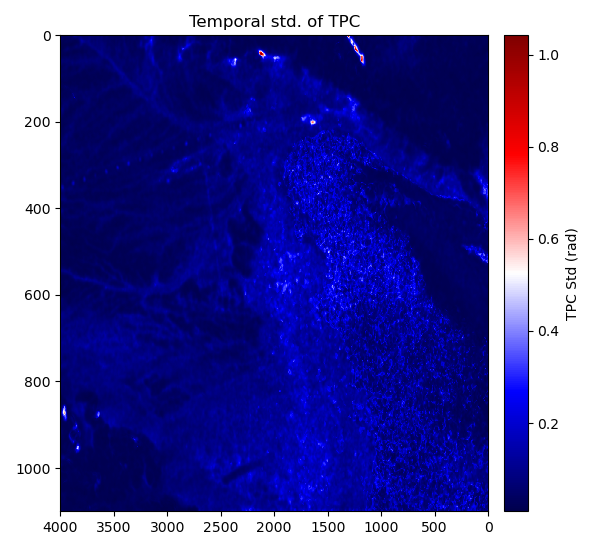

: 

In [8]:
# plot it. 
plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(avg_TPCs,aspect='auto',interpolation='none')
plt.colorbar(orientation='vertical',pad=0.03,label='Avg TPC (rad)'); plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.title('Temporal Avg of TPC')
plt.show()
plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(std_TPCs,aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03,label='TPC Std (rad)'); plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.title('Temporal std. of TPC')
plt.show()

In [ ]:
# save it as an ISCE-readable file. 
driver=gdal.GetDriverByName('ISCE')
#saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/'
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'

save_file_name = 'TPC_avgs.r4'
colds = driver.Create(saveDir+save_file_name,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(avg_TPCs)
colds=None
print('Average TPC for each pixel over time saved.')

save_file_name = 'TPC_stds.r4'
colds = driver.Create(saveDir+save_file_name,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(std_TPCs)
colds=None
print('Standard deviation of TPC for each pixel over time saved.')


Average TPC for each pixel over time saved.
Standard deviation of TPC for each pixel over time saved.
